In [17]:
import re
import numpy as np
from PIL import Image, ImageOps
import shutil
import os
import json

from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop


In [26]:
def read_image(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [4]:
#достаем данные из гугл диска
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
#распаковываем архив
!unzip /content/gdrive/MyDrive/archive.zip

Archive:  /content/gdrive/MyDrive/archive.zip
   creating: archive/
   creating: archive/s20/
  inflating: archive/s20/10.pgm      
  inflating: archive/s20/9.pgm       
  inflating: archive/s20/4.pgm       
  inflating: archive/s20/7.pgm       
  inflating: archive/s20/8.pgm       
  inflating: archive/s20/6.pgm       
  inflating: archive/s20/1.pgm       
  inflating: archive/s20/3.pgm       
  inflating: archive/s20/2.pgm       
  inflating: archive/s20/5.pgm       
   creating: archive/s18/
  inflating: archive/s18/10.pgm      
  inflating: archive/s18/9.pgm       
  inflating: archive/s18/4.pgm       
  inflating: archive/s18/7.pgm       
  inflating: archive/s18/8.pgm       
  inflating: archive/s18/6.pgm       
  inflating: archive/s18/1.pgm       
  inflating: archive/s18/3.pgm       
  inflating: archive/s18/2.pgm       
  inflating: archive/s18/5.pgm       
   creating: archive/s36/
  inflating: archive/s36/10.pgm      
  inflating: archive/s36/9.pgm       
  inflating: archi

In [19]:
img = read_image('archive/s1/1.pgm')
img.shape

(112, 92)

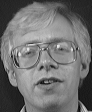

In [21]:
Image.open("archive/s1/1.pgm")

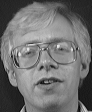

In [22]:
Image.open("archive/s2/1.pgm")

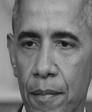

In [23]:
Image.open("archive/s41/1.pgm")

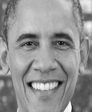

In [24]:
Image.open("archive/s41/2.pgm")

In [5]:
size = 2
total_sample_size = 10000

In [25]:
def get_data(size, total_sample_size):
    image = read_image('archive/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    image = image[::size, ::size]
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            img1 = read_image('archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            y_imposite[count] = 0
            count += 1
            
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [14]:
X, Y = get_data(size, total_sample_size)

In [9]:
# для обучения, выполнять не нужно 
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, input_shape=input_shape, data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [16]:
# выполняем ячейку
input_dim = x_train.shape[2:]
print(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

(1, 56, 46)


In [9]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


In [ ]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [ ]:
epochs = 13
rms = RMSprop()
model = Model([img_a, img_b], distance)

In [22]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=epochs)

Epoch 1/13
88/88 - 3s - loss: 0.1869 - val_loss: 0.1920
Epoch 2/13
88/88 - 1s - loss: 0.1117 - val_loss: 0.0933
Epoch 3/13
88/88 - 1s - loss: 0.0799 - val_loss: 0.1012
Epoch 4/13
88/88 - 1s - loss: 0.0652 - val_loss: 0.0749
Epoch 5/13
88/88 - 1s - loss: 0.0552 - val_loss: 0.0475
Epoch 6/13
88/88 - 1s - loss: 0.0483 - val_loss: 0.0364
Epoch 7/13
88/88 - 1s - loss: 0.0436 - val_loss: 0.0309
Epoch 8/13
88/88 - 1s - loss: 0.0406 - val_loss: 0.0368
Epoch 9/13
88/88 - 1s - loss: 0.0372 - val_loss: 0.0284
Epoch 10/13
88/88 - 1s - loss: 0.0342 - val_loss: 0.0220
Epoch 11/13
88/88 - 1s - loss: 0.0326 - val_loss: 0.0204
Epoch 12/13
88/88 - 1s - loss: 0.0301 - val_loss: 0.0272
Epoch 13/13
88/88 - 1s - loss: 0.0282 - val_loss: 0.0176


In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [ ]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [ ]:
compute_accuracy(pred, y_test)

0.9627304825421734

In [ ]:
#дообучение нейронки на нового человека

#генерация пар с этим человеком для дообучения
def get_pairs(number, size, total_sample_size): #number - номер папки человека
  path, dirs, files = next(os.walk("archive"))
  dirs_count = len(dirs)

  image_p = Image.open('archive/s' + str(number) + '/' + str(1) + '.pgm')
  image = np.array(image_p)
  image = image[::size, ::size]
  dim1 = image.shape[0]
  dim2 = image.shape[1]
  
  count = 0
    
  x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
  y_genuine = np.zeros([total_sample_size, 1])

  for i in range(len(dirs)):
        for j in range(int(total_sample_size/len(dirs))):
            ind1 = 0
            ind2 = 0
            
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            img1 = read_image('archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            y_genuine[count] = 1
            count += 1

  count = 0
  x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
  y_imposite = np.zeros([total_sample_size, 1])
  
  for i in range(int(total_sample_size/10)):
      for j in range(10):
          
          while True:
              ind1 = np.random.randint(len(dirs))
              ind2 = np.random.randint(len(dirs))
              if ind1 != ind2:
                  break
                  
          img1 = read_image('archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
          img2 = read_image('archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

          img1 = img1[::size, ::size]
          img2 = img2[::size, ::size]

          x_imposite_pair[count, 0, 0, :, :] = img1
          x_imposite_pair[count, 1, 0, :, :] = img2
          y_imposite[count] = 0
          count += 1
          
  X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
  Y = np.concatenate([y_genuine, y_imposite], axis=0)

  return X, Y

In [ ]:
X, Y = get_pairs(41, 2, 2000)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=30)

Epoch 1/30
18/18 - 0s - loss: 0.0249 - val_loss: 0.0236
Epoch 2/30
18/18 - 0s - loss: 0.0234 - val_loss: 0.0265
Epoch 3/30
18/18 - 0s - loss: 0.0215 - val_loss: 0.0190
Epoch 4/30
18/18 - 0s - loss: 0.0218 - val_loss: 0.0213
Epoch 5/30
18/18 - 0s - loss: 0.0207 - val_loss: 0.0238
Epoch 6/30
18/18 - 0s - loss: 0.0207 - val_loss: 0.0203
Epoch 7/30
18/18 - 0s - loss: 0.0194 - val_loss: 0.0221
Epoch 8/30
18/18 - 0s - loss: 0.0185 - val_loss: 0.0182
Epoch 9/30
18/18 - 0s - loss: 0.0192 - val_loss: 0.0213
Epoch 10/30
18/18 - 0s - loss: 0.0170 - val_loss: 0.0202
Epoch 11/30
18/18 - 0s - loss: 0.0178 - val_loss: 0.0218
Epoch 12/30
18/18 - 0s - loss: 0.0173 - val_loss: 0.0204
Epoch 13/30
18/18 - 0s - loss: 0.0174 - val_loss: 0.0203
Epoch 14/30
18/18 - 0s - loss: 0.0176 - val_loss: 0.0184
Epoch 15/30
18/18 - 0s - loss: 0.0165 - val_loss: 0.0194
Epoch 16/30
18/18 - 0s - loss: 0.0161 - val_loss: 0.0194
Epoch 17/30
18/18 - 0s - loss: 0.0156 - val_loss: 0.0187
Epoch 18/30
18/18 - 0s - loss: 0.0155 - 

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
compute_accuracy(pred, y_test)

In [ ]:
model.save("model")